#### Title: Predicting crime with green space data: insights from the tree equity dataset
#### Author: Victor De Lima

# Initial Set Up

Libraries

In [41]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shapely.geometry as shp_geom
import shapely.wkt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import redivis
import matplotlib.ticker as mtick

Crime Open Database (Green Space Challenge, 2023a)

In [42]:
dui_data = redivis.table("crime_open_database_filtered:h25r").to_dataframe() 

  0%|          | 0/1229134 [00:00<?, ?it/s]

Tree Equity Score tables (Green Space Challenge, 2023b). The tables below correspond to the cities available in the Crime Open Database.

In [ ]:
arizona = redivis.table("arizona:srbt").to_dataframe()
california = redivis.table("california:xdnh").to_dataframe()
colorado = redivis.table("colorado:4t5p").to_dataframe()
illinois = redivis.table("illinois:fk5n").to_dataframe()
kentucky = redivis.table("kentucky:c8va").to_dataframe()
massachusetts = redivis.table("massachusetts:tgcz").to_dataframe()
missouri = redivis.table("missouri:8sb7").to_dataframe()
montana = redivis.table("montana:2f0y").to_dataframe()
new_york = redivis.table("new_york:c4xt").to_dataframe()
tennessee = redivis.table("tennessee:fa9a").to_dataframe()
texas = redivis.table("texas:6rht").to_dataframe()
virginia = redivis.table("virginia:bd8y").to_dataframe()
washington = redivis.table("washington:ede4").to_dataframe()


Combine the required states tables into one.

In [44]:
# Concatenate the dataframes
df_to_combine = [arizona, california, colorado, illinois, kentucky, 
       massachusetts, missouri, montana, new_york, tennessee, 
       texas, virginia, washington]

tree_equity = pd.concat(df_to_combine, ignore_index=True)

Supplemental tables for geospatial visualization (City of New York, 2022)

In [45]:
# Get NY boundary data
url = "https://data.cityofnewyork.us/resource/wmsu-5muw.geojson"
params = {"$limit": 100000}
response = requests.get(url, params=params)

# create geopandas object
data = response.json()
ny_boundary = gpd.GeoDataFrame.from_features(data, crs="EPSG:4326")

# Data Cleaning and EDA

## Crime Open Database

Initial look at the data

In [46]:
print(f'shape: {dui_data.shape}')
display(dui_data.head())

shape: (1229134, 7)


,uid,city_name,offense_type,date_single,longitude,latitude,census_block
0,7865723,Fort Worth,driving under the influence,2007-01-08 00:00:00,-97.34375,32.686276,484391048033013
1,8159394,Fort Worth,driving under the influence,2011-02-23 00:00,-97.34375,32.686276,484391048033013
2,8105399,Fort Worth,driving under the influence,2010-04-30 00:00,-97.34375,32.686276,484391048033013
3,7865723,Fort Worth,driving under the influence,2007-01-08 00:00:00,-97.34375,32.686276,484391048033013
4,832434,Austin,driving under the influence,2014-02-15 00:26,-97.68750,30.357906,484530018131001


Convert `census_block` id to `blockgroup_id` to match the Tree Equity Data census block level (US Census Bureau, 2021), drop unnecesary colums and create a `year` column.

In [47]:
# Convert census_block
dui_data['blockgroup_id'] = dui_data['census_block'].astype(
    str).str.slice(stop=-3)
dui_data['blockgroup_id'] = dui_data['blockgroup_id'].astype(int)
# Drop unnecesary columns
dui_data = dui_data.drop(['census_block', 'uid', 'offense_type'],
                         axis=1)
# Create a year column
dui_data['date_single'] = pd.to_datetime(dui_data['date_single'])
dui_data['year'] = dui_data['date_single'].dt.year

# Check
display(dui_data.head())

,city_name,date_single,longitude,latitude,blockgroup_id,year
0,Fort Worth,2007-01-08 00:00:00,-97.34375,32.686276,484391048033,2007
1,Fort Worth,2011-02-23 00:00:00,-97.34375,32.686276,484391048033,2011
2,Fort Worth,2010-04-30 00:00:00,-97.34375,32.686276,484391048033,2010
3,Fort Worth,2007-01-08 00:00:00,-97.34375,32.686276,484391048033,2007
4,Austin,2014-02-15 00:26:00,-97.68750,30.357906,484530018131,2014


Check number of entries per city and year.

In [48]:
pd.pivot_table(dui_data, index='city_name', columns='year',
               values='date_single', aggfunc='count')

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
city_name,,,,,,,,,,,,,,,
Austin,28580.0,30941.0,26974.0,16780.0,23819.0,22717.0,23692.0,22003.0,21271.0,20060.0,17847.0,15836.0,15423.0,11767.0,10043.0
Boston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606.0,522.0,482.0,448.0,342.0,320.0
Colorado Springs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10121.0,11636.0,11591.0,10826.0,9062.0,10321.0
Detroit,NaN,NaN,11390.0,5351.0,6585.0,4121.0,2566.0,2234.0,2326.0,2369.0,3491.0,2650.0,2537.0,1041.0,895.0
Fort Worth,10526.0,10938.0,9683.0,4523.0,5954.0,6037.0,4982.0,4573.0,4982.0,4409.0,4647.0,4600.0,NaN,NaN,NaN
Kansas City,NaN,NaN,720.0,1427.0,7297.0,5787.0,3919.0,4087.0,3788.0,3703.0,3336.0,3478.0,2777.0,3979.0,4107.0
Louisville,1111.0,616.0,86.0,27.0,40.0,16.0,12.0,8.0,8.0,16.0,8.0,32.0,8.0,8.0,NaN
Memphis,2824.0,5582.0,6019.0,3214.0,5632.0,4700.0,4089.0,3160.0,2565.0,2461.0,2146.0,1886.0,2083.0,1508.0,1344.0
Mesa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4896.0,4973.0,4279.0,4850.0,4821.0,2790.0


Due to the missingness, lets only consider DUIs from 2016-2018

In [49]:
dui_data = dui_data[(dui_data['year'] == 2016) | (
    dui_data['year'] == 2017) | (dui_data['year'] == 2018)]

# Check
display(pd.pivot_table(dui_data, index='city_name', columns='year', values='date_single', aggfunc='count'))

year,2016,2017,2018
city_name,,,
Austin,20060,17847,15836
Boston,606,522,482
Colorado Springs,10121,11636,11591
Detroit,2369,3491,2650
Fort Worth,4409,4647,4600
Kansas City,3703,3336,3478
Louisville,16,8,32
Memphis,2461,2146,1886
Mesa,4896,4973,4279


Agregate by census block

In [50]:
dui_data_agg = dui_data.groupby('blockgroup_id').size().reset_index(name='count')
dui_data_agg = dui_data_agg.rename(columns={'count': 'duis'})

# Check
dui_data_agg.head()

,blockgroup_id,duis
0,40134201041,44
1,40134201042,56
2,40134201051,48
3,40134201052,44
4,40134201053,28


Check the distribution of DUI frequencies. We can see that blockgroups having more than 40 DUIs is rare.

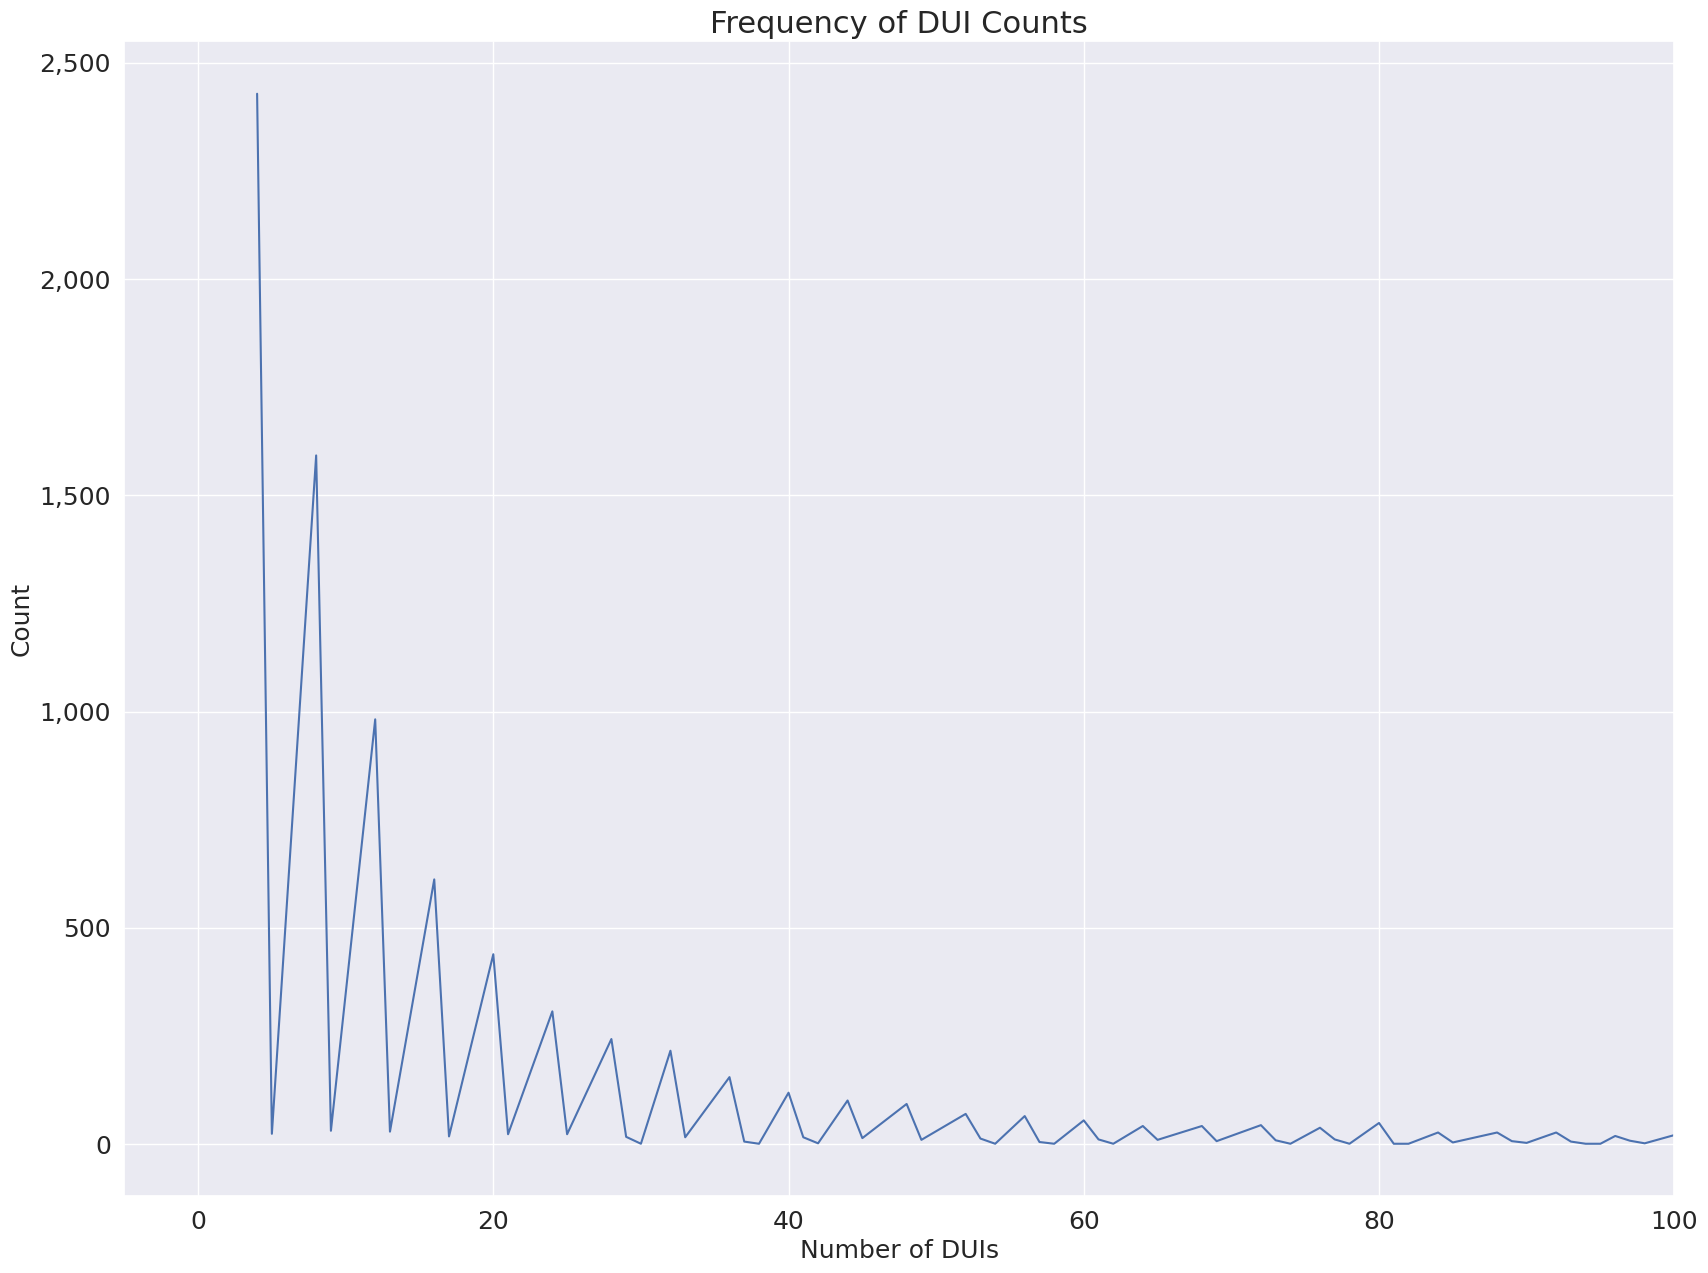

In [51]:
dui_counts = dui_data_agg['duis'].value_counts().sort_index()
dui_counts = pd.DataFrame({'frequency': dui_counts.values}, index=dui_counts.index)
dui_counts = dui_counts.rename_axis('dui_number').reset_index()
dui_counts = dui_data_agg['duis'].value_counts().sort_index()

# Plot
dui_counts.plot(kind='line')
plt.xlim(-5, 100)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of DUIs', fontsize=18)
plt.ylabel('Count', fontsize=18)
formatter = mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Frequency of DUI Counts', fontsize=22)
plt.show()

## Tree Equity data  

Initial look.

In [52]:
display(tree_equity.shape)
display(tree_equity.head())

(77578, 34)

,geometry,tesctyscor,priority,core_m,asthma,area,tc_gap,tes,geoid,total_pop,...,pctpov,county,ment_hlth,tc_goal,medhhinc,core_norm,popadjust,biome,ua_name,incorpname
0,"POLYGON ((-111.65337 33.36478, -111.65563 33.3...",79.519892,0.254820,33.4,10.1,1.224018,0.123837,81.839024,40134226412,1355,...,0.241328,Maricopa County,13.6,-1.0,66875,0.656214,1.2,Desert,"Phoenix--Mesa, AZ",Mesa
1,"POLYGON ((-111.79471 33.40654, -111.79470 33.4...",79.519892,0.404654,25.3,11.2,0.399336,0.104214,75.730378,40134218023,1005,...,0.426866,Maricopa County,17.8,-1.0,55994,0.207598,1.0,Desert,"Phoenix--Mesa, AZ",Mesa
2,"POLYGON ((-111.78830 33.40589, -111.78830 33.4...",79.519892,0.491772,25.3,11.2,0.245312,0.093609,73.506742,40134218021,1735,...,0.682997,Maricopa County,17.8,-1.0,28068,0.207598,0.8,Desert,"Phoenix--Mesa, AZ",Mesa
3,"POLYGON ((-111.79472 33.40418, -111.79535 33.4...",79.519892,0.330674,25.3,11.2,0.634126,0.073440,86.023920,40134218022,2672,...,0.446510,Maricopa County,17.8,-1.0,55987,0.207598,0.8,Desert,"Phoenix--Mesa, AZ",Mesa
4,"POLYGON ((-111.85909 33.35721, -111.85908 33.3...",79.519892,0.356165,32.6,9.9,1.296515,0.152658,68.708594,40134222151,2174,...,0.225254,Maricopa County,13.1,-1.0,66944,0.613334,1.2,Desert,"Phoenix--Mesa, AZ",Mesa


Adjust the column names so they are more clear. See Appendix for documentation.

In [53]:
tree_equity = tree_equity.rename(columns={
    'geoid': 'blockgroup_id', 
    'total_pop': 'total_population',
    'pctpov': 'poverty_pct',
    'pctpoc': 'people_of_color_pct',
    'unemplrate': 'unemployment_rate',
    'medhhinc': 'median_household_income',
    'dep_ratio': 'dependency_ratio',
    'child_perc': 'children_pct',
    'seniorperc': 'seniors_pct',
    'treecanopy': 'canopy_pct',
    'area': 'area_km2',
    'avg_temp': 'summer_temperature_avg',
    'ua_name': 'urban_area_name',
    'incorpname': 'incorp_place_name',
    'congressio': 'congressional_district',
    'biome': 'biome',
    'bgpopdense': 'population_density',
    'popadjust': 'population_adjustment_factor',
    'tc_gap': 'tree_canopy_gap',
    'tc_goal': 'tree_canopy_goal',
    'phys_hlth': 'physically_challenged_pct',
    'ment_hlth': 'mentally_challenged_pct',
    'asthma': 'asthma_challenged_pct',
    'core_m': 'heart_challenged_male_pct',
    'core_w': 'heart_challenged_female_pct',
    'core_norm': 'norm_total_heart_challenged',
    'healthnorm': 'norm_health_index',
    'priority': 'priority_index',
    'tes': 'tree_equity_score_block',
    'tesctyscor': 'tree_equity_score_incorp_place'
    })
tree_equity.head()

,geometry,tree_equity_score_incorp_place,priority_index,heart_challenged_male_pct,asthma_challenged_pct,area_km2,tree_canopy_gap,tree_equity_score_block,blockgroup_id,total_population,...,poverty_pct,county,mentally_challenged_pct,tree_canopy_goal,median_household_income,norm_total_heart_challenged,population_adjustment_factor,biome,urban_area_name,incorp_place_name
0,"POLYGON ((-111.65337 33.36478, -111.65563 33.3...",79.519892,0.254820,33.4,10.1,1.224018,0.123837,81.839024,40134226412,1355,...,0.241328,Maricopa County,13.6,-1.0,66875,0.656214,1.2,Desert,"Phoenix--Mesa, AZ",Mesa
1,"POLYGON ((-111.79471 33.40654, -111.79470 33.4...",79.519892,0.404654,25.3,11.2,0.399336,0.104214,75.730378,40134218023,1005,...,0.426866,Maricopa County,17.8,-1.0,55994,0.207598,1.0,Desert,"Phoenix--Mesa, AZ",Mesa
2,"POLYGON ((-111.78830 33.40589, -111.78830 33.4...",79.519892,0.491772,25.3,11.2,0.245312,0.093609,73.506742,40134218021,1735,...,0.682997,Maricopa County,17.8,-1.0,28068,0.207598,0.8,Desert,"Phoenix--Mesa, AZ",Mesa
3,"POLYGON ((-111.79472 33.40418, -111.79535 33.4...",79.519892,0.330674,25.3,11.2,0.634126,0.073440,86.023920,40134218022,2672,...,0.446510,Maricopa County,17.8,-1.0,55987,0.207598,0.8,Desert,"Phoenix--Mesa, AZ",Mesa
4,"POLYGON ((-111.85909 33.35721, -111.85908 33.3...",79.519892,0.356165,32.6,9.9,1.296515,0.152658,68.708594,40134222151,2174,...,0.225254,Maricopa County,13.1,-1.0,66944,0.613334,1.2,Desert,"Phoenix--Mesa, AZ",Mesa


## Combining dataframes

Perform an inner join by `blockgroup_id`

In [54]:
blockgroup_dataset = dui_data_agg.merge(
    tree_equity, on='blockgroup_id', how='inner')

Check combined dataframe

In [55]:
display(blockgroup_dataset.shape)
display(blockgroup_dataset.head())

(8040, 35)

,blockgroup_id,duis,geometry,tree_equity_score_incorp_place,priority_index,heart_challenged_male_pct,asthma_challenged_pct,area_km2,tree_canopy_gap,tree_equity_score_block,...,poverty_pct,county,mentally_challenged_pct,tree_canopy_goal,median_household_income,norm_total_heart_challenged,population_adjustment_factor,biome,urban_area_name,incorp_place_name
0,40134201041,44,"POLYGON ((-111.63869 33.43617, -111.63875 33.4...",79.519892,0.358344,33.5,10.2,2.564556,0.131249,72.932432,...,0.375656,Maricopa County,12.6,-1.0,57500,0.638615,1.2,Desert,"Phoenix--Mesa, AZ",Mesa
1,40134201042,56,"POLYGON ((-111.64998 33.42289, -111.64999 33.4...",79.519892,0.249454,33.5,10.2,5.058679,0.126815,81.794078,...,0.108766,Maricopa County,12.6,-1.0,75139,0.638615,1.2,Desert,"Phoenix--Mesa, AZ",Mesa
2,40134201051,48,"POLYGON ((-111.67256 33.45145, -111.67279 33.4...",79.519892,0.274358,35.6,10.0,1.535234,0.127990,79.790834,...,0.145152,Maricopa County,12.4,-1.0,92125,0.755427,1.2,Desert,"Phoenix--Mesa, AZ",Mesa
3,40134201052,44,"POLYGON ((-111.64026 33.45135, -111.64060 33.4...",79.519892,0.308107,35.6,10.0,4.520136,0.127204,77.444319,...,0.238989,Maricopa County,12.4,-1.0,99583,0.755427,1.2,Desert,"Phoenix--Mesa, AZ",Mesa
4,40134201053,28,"POLYGON ((-111.67678 33.44935, -111.67694 33.4...",79.519892,0.335557,35.6,10.0,1.504532,0.087006,83.197776,...,0.235191,Maricopa County,12.4,-1.0,82827,0.755427,1.2,Desert,"Phoenix--Mesa, AZ",Mesa


Since the number of DUIs (`duis`) is a calculated, rather than provided column, let's perform a sanity check by looking at a scatterplot against the Tree Equity Score.

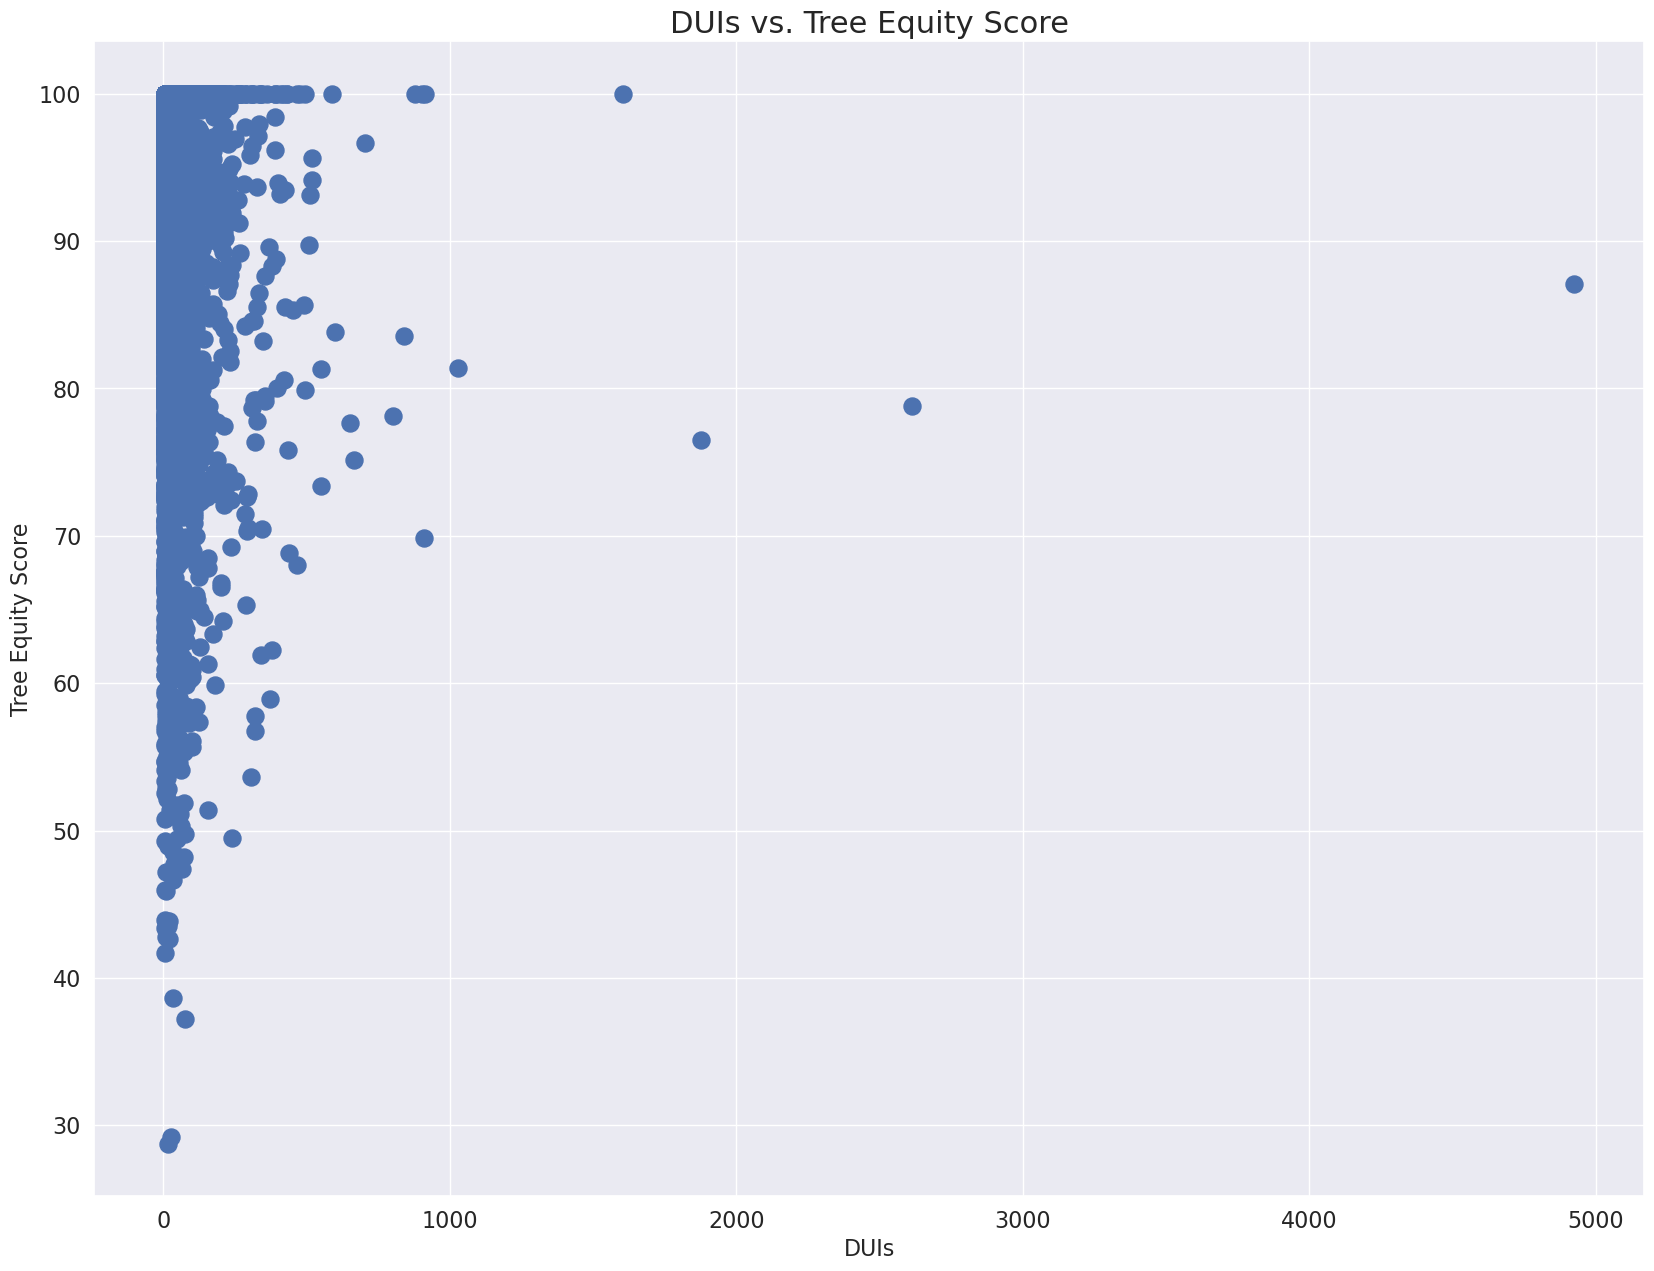

In [56]:
plt.scatter(blockgroup_dataset['duis'], blockgroup_dataset['tree_equity_score_block'], s=150)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('DUIs vs. Tree Equity Score', fontsize=22)
plt.xlabel('DUIs', fontsize=16)
plt.ylabel('Tree Equity Score', fontsize=16)
plt.show()

Let's remove outliers bigger than 3 standard deviations in the DUI count.

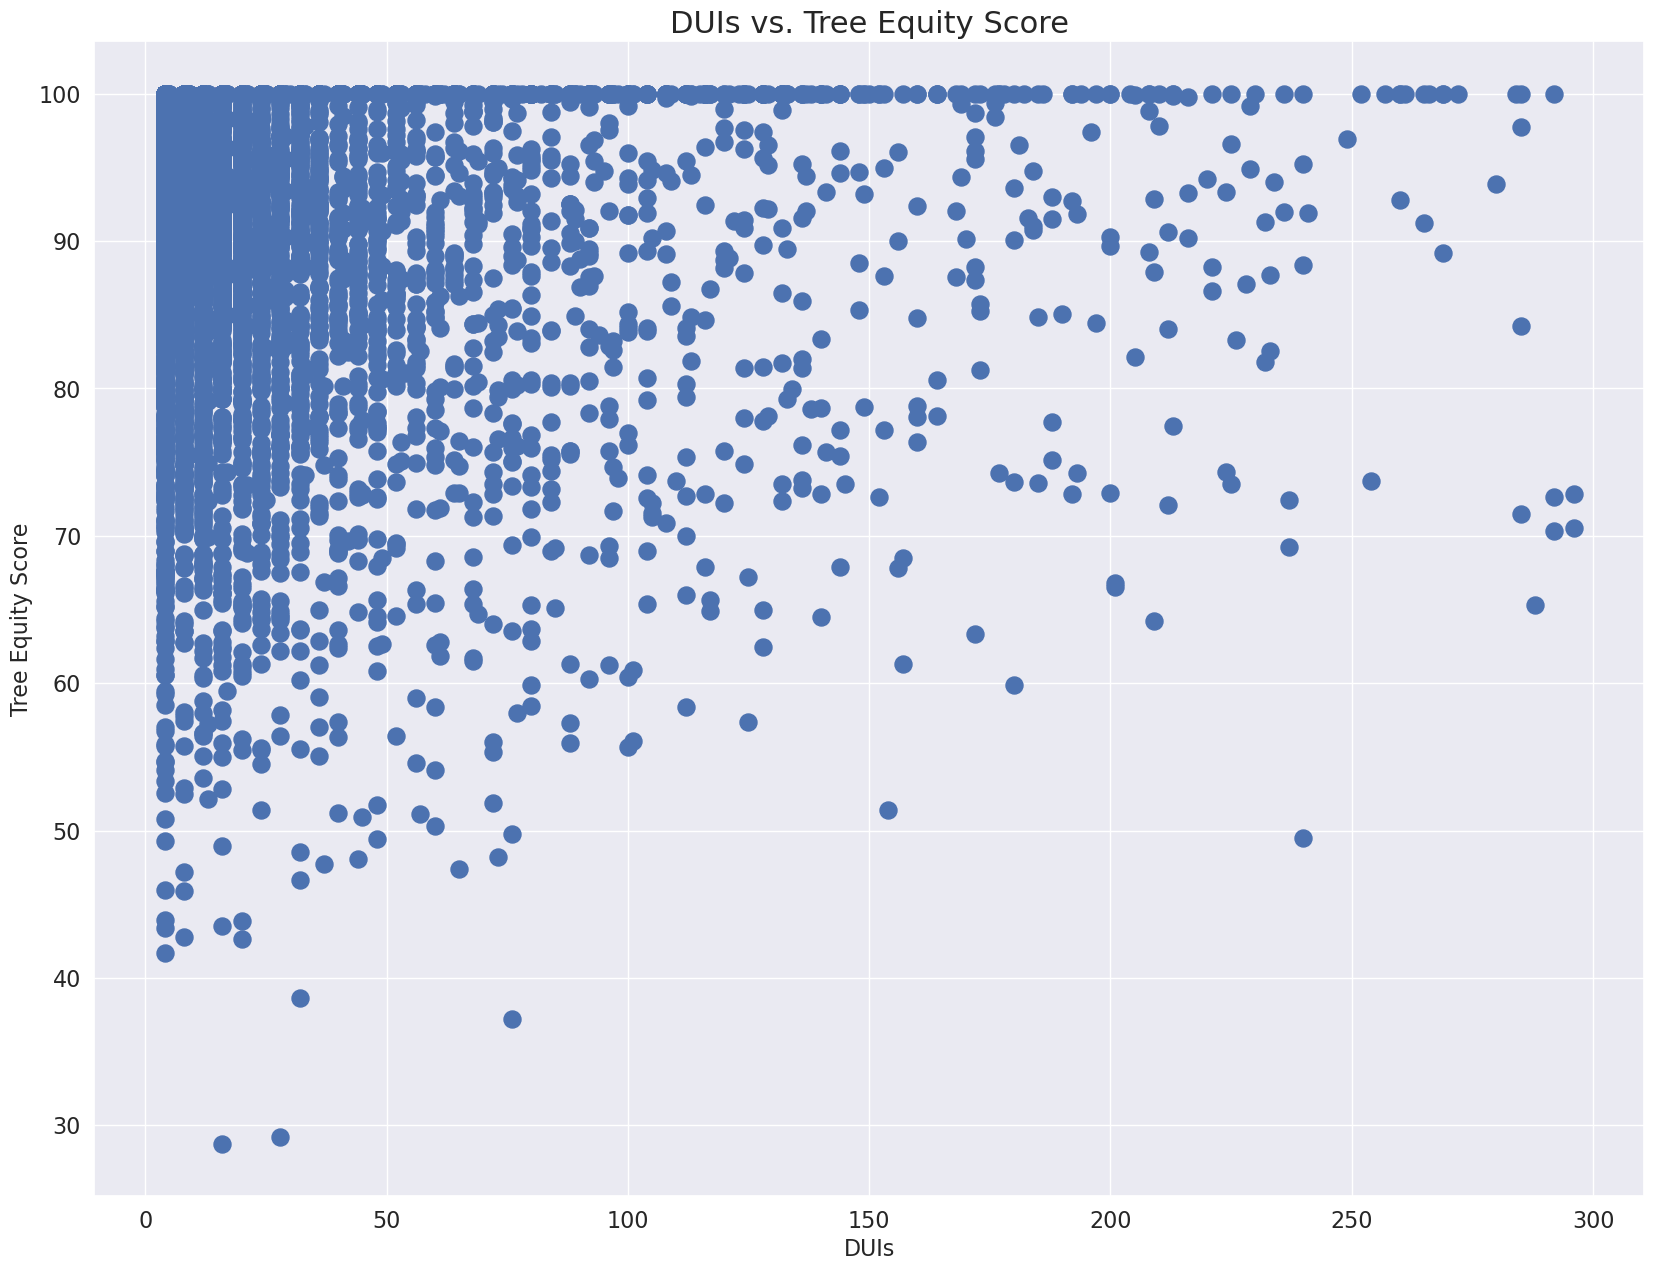

In [57]:
#  rate
# calculate mean and standard deviation
mean = blockgroup_dataset['duis'].mean()
std = blockgroup_dataset['duis'].std()
blockgroup_dataset = blockgroup_dataset[(blockgroup_dataset['duis'] >= mean - 3 * std) & (blockgroup_dataset['duis'] <= mean + 3 * std)]

# Plot
plt.scatter(blockgroup_dataset['duis'], blockgroup_dataset['tree_equity_score_block'], s=150)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('DUIs vs. Tree Equity Score', fontsize=22)
plt.xlabel('DUIs', fontsize=16)
plt.ylabel('Tree Equity Score', fontsize=16)
plt.show()

The following columns are removed for the following reasons: 

* `geometry`, `source`, `congressional_district`, `population_adjustment_factor`, `incorp_place_name`, `county`, `state`, `blockgroup_id` are not relevant to the analysis.
* `tree_equity_score_incorp_place` overlaps `tree_equity_score_block`.
* `tree_canopy_goal`, and `canopy_pct` are mostly -1 due to automatic setting by data maintainer if source is 'ED' (which is almost all entries)  and `tree_canopy_gap since` it depends on `tree_canopy_goal`.
* `urban_area_name` has the same information as `incorp_place_name`.
*  `heart_challenged_female_pct` and `heart_challenged_male_pct` measures the same dimension as `norm_total_heart_challenged`.
* `physically_challenged_pct`, `mentally_challenged_pct`, and `asthma_challenged_pct` are highly correlated to `norm_total_heart_challenged`, so we remove them to avoid multicllinearity.
* `priority_index` as its highly correlated to race and health variables.

In [58]:
blockgroup_dataset_subset = blockgroup_dataset.drop(['geometry', 'tree_equity_score_incorp_place', 'congressional_district', 'source', 'tree_canopy_goal','canopy_pct', 'urban_area_name', 'population_adjustment_factor', 'tree_canopy_gap', 'heart_challenged_female_pct', 'heart_challenged_male_pct', 'incorp_place_name', 'county', 'blockgroup_id', 'physically_challenged_pct', 'asthma_challenged_pct', 'mentally_challenged_pct', 'priority_index',  'state'], axis=1)

Check for missingness

In [59]:
blockgroup_dataset_subset.isnull().sum()


duis                             0
area_km2                         0
tree_equity_score_block          0
total_population                 0
population_density               0
norm_health_index                0
children_pct                     0
summer_temperature_avg           0
people_of_color_pct              0
seniors_pct                      0
unemployment_rate                0
dependency_ratio                 0
poverty_pct                      0
median_household_income          0
norm_total_heart_challenged     17
biome                          209
dtype: int64

Remove rows wherer `norm_total_heart_challenged` has missing entries. Missing from the `biome` variable will be sorted out during one-hot encoding.

In [60]:
blockgroup_dataset_subset = blockgroup_dataset_subset.dropna(subset=['norm_total_heart_challenged']) 
blockgroup_dataset_subset.isnull().sum()


duis                             0
area_km2                         0
tree_equity_score_block          0
total_population                 0
population_density               0
norm_health_index                0
children_pct                     0
summer_temperature_avg           0
people_of_color_pct              0
seniors_pct                      0
unemployment_rate                0
dependency_ratio                 0
poverty_pct                      0
median_household_income          0
norm_total_heart_challenged      0
biome                          209
dtype: int64

One-hot encode `biome`

In [61]:
biome_encoded = pd.get_dummies(blockgroup_dataset_subset['biome'], prefix='biome', dummy_na=False)
biome_encoded.columns = biome_encoded.columns.str.lower() # make lowercase

# concatenate the original dataframe and the encoded dataframe
blockgroup_dataset_subset = pd.concat([blockgroup_dataset_subset, biome_encoded], axis=1)

# drop the original 'biome' column
blockgroup_dataset_subset = blockgroup_dataset_subset.drop('biome', axis=1)

Remove rows with no median household income data

In [62]:
blockgroup_dataset_subset = blockgroup_dataset_subset[blockgroup_dataset_subset['median_household_income'] != 0]

Check cleaned analytical dataframe `blockgroup_dataset_subset`.

In [63]:
print(f'Shape: {blockgroup_dataset_subset.shape}')
display(blockgroup_dataset_subset.head())

Shape: (7556, 18)


,duis,area_km2,tree_equity_score_block,total_population,population_density,norm_health_index,children_pct,summer_temperature_avg,people_of_color_pct,seniors_pct,unemployment_rate,dependency_ratio,poverty_pct,median_household_income,norm_total_heart_challenged,biome_desert,biome_forest,biome_grassland
0,44,2.564556,72.932432,2859,1114.812856,0.402649,0.165792,106.623453,0.229101,0.408884,0.061361,1.351151,0.375656,57500,0.638615,1,0,0
1,56,5.058679,81.794078,3092,611.226765,0.402649,0.237710,106.117972,0.222833,0.081824,0.013372,0.469582,0.108766,75139,0.638615,1,0,0
2,48,1.535234,79.790834,1805,1175.716536,0.383918,0.164543,106.350146,0.151247,0.127424,0.067325,0.412363,0.145152,92125,0.755427,1,0,0
3,44,4.520136,77.444319,2611,577.637487,0.383918,0.269245,106.509464,0.245500,0.172348,0.041536,0.790809,0.238989,99583,0.755427,1,0,0
4,28,1.504532,83.197776,1705,1133.242763,0.383918,0.187097,106.879239,0.136657,0.184751,0.118268,0.591970,0.235191,82827,0.755427,1,0,0


## Additional Visualizations

In [64]:
# setup geo dataframe
geo_viz_df = blockgroup_dataset[['geometry', 'tree_equity_score_block', 'duis']].copy()
gdf = gpd.GeoDataFrame(geo_viz_df, geometry='geometry')

Heatmap of Tree Equity Score per census block in New York

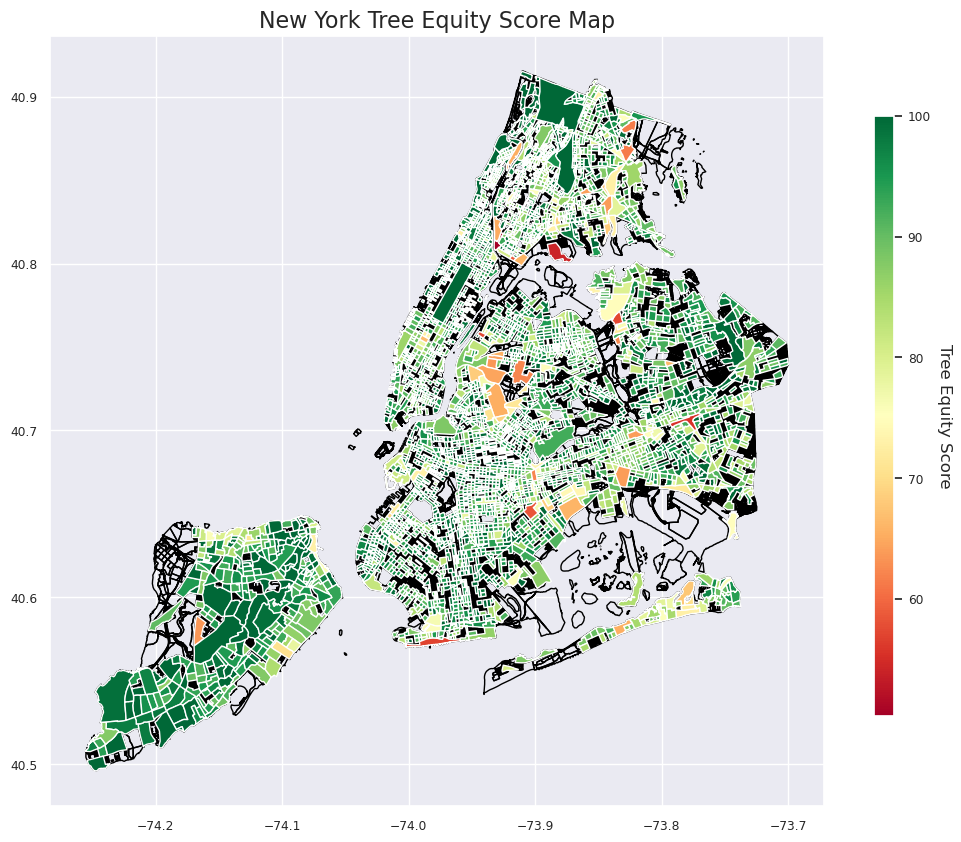

In [65]:
render_NY_map_tree_equity = True

if render_NY_map_tree_equity == True:

    ny_blockgroups = gdf[gdf.intersects(ny_boundary.unary_union)]
    fig, ax = plt.subplots(figsize=(10,10))

    # Boundaries
    ny_boundary.plot(ax=ax, facecolor='none', edgecolor='black')

    # Block groups
    ny_blockgroups.plot(column='tree_equity_score_block', cmap='RdYlGn', ax=ax)

    # Format
    vmin, vmax = ny_blockgroups['tree_equity_score_block'].min(), ny_blockgroups['tree_equity_score_block'].max()
    cbar = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar.set_array([])
    # create colorbar
    cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(cbar, cax=cbar_ax)
    cbar.set_label('Tree Equity Score', fontsize=12, rotation=270, labelpad=15)
    ax.set_title('New York Tree Equity Score Map', fontsize=16)

    plt.show()


Heatmap of DU per census block in New York

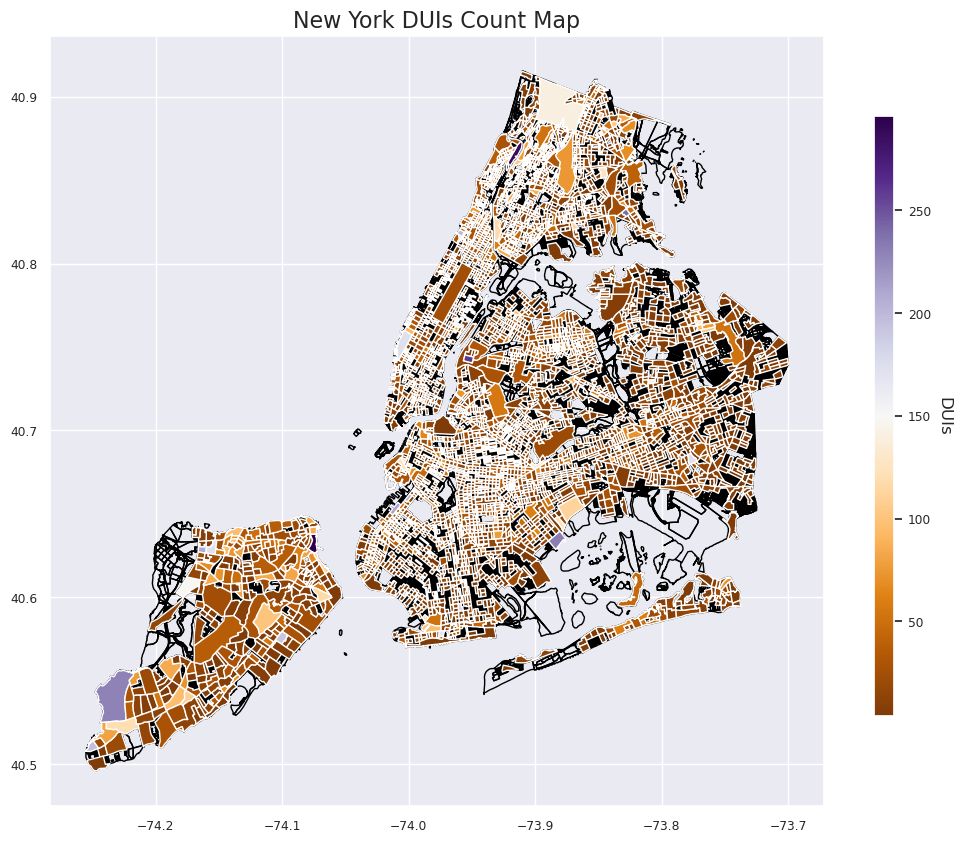

In [66]:
render_NY_map_tree_equity = True

if render_NY_map_tree_equity == True:

    ny_blockgroups = gdf[gdf.intersects(ny_boundary.unary_union)]
    fig, ax = plt.subplots(figsize=(10,10))

    # Boundaries
    ny_boundary.plot(ax=ax, facecolor='none', edgecolor='black')

    # Block groups
    ny_blockgroups.plot(column='duis', cmap='PuOr', ax=ax)

    # Format
    vmin, vmax = ny_blockgroups['duis'].min(), ny_blockgroups['duis'].max()
    cbar = plt.cm.ScalarMappable(cmap='PuOr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar.set_array([])
    # create colorbar
    cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(cbar, cax=cbar_ax)
    cbar.set_label('DUIs', fontsize=12, rotation=270, labelpad=15)
    ax.set_title('New York DUIs Count Map', fontsize=16)

    plt.show()


Correlation plot.

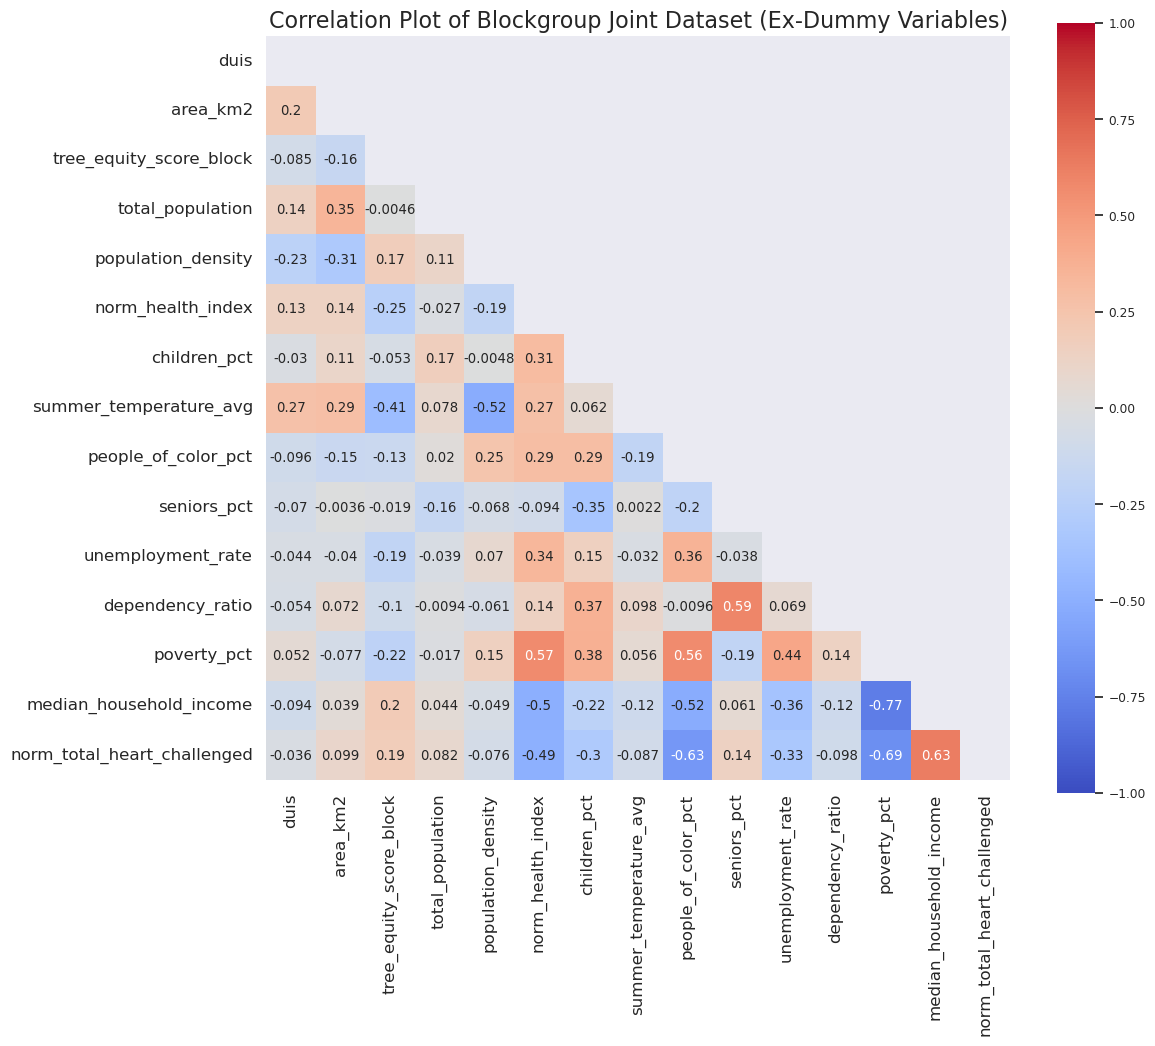

In [67]:
# Exclude the biome dummy variables
dummy_cols = [col for col in blockgroup_dataset_subset.columns if col.startswith('biome_')]
vars_to_include = [col for col in blockgroup_dataset_subset.columns if col not in dummy_cols]

# Create heatmap plot of correlation coefficients
corr_df = blockgroup_dataset_subset[vars_to_include].corr()

# Hide diagonal and upper diagonal
mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create heatmap plot of correlation coefficients
sns.set(font_scale=0.8)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, square=True)
plt.title('Correlation Plot of Blockgroup Joint Dataset (Ex-Dummy Variables)', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
plt.grid(False)
plt.show()

# Experiments

Data pre-processing

In [68]:
# Split into X and y

X = blockgroup_dataset_subset.drop(['duis'], axis=1)
y = blockgroup_dataset_subset['duis']

# Normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


## Analytical Dataframe - Linear Regression

Get statistical output using `statsmodel`

In [69]:
# Reset indices
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Fit the OLS model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   duis   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     124.9
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:34:13   Log-Likelihood:                -37151.
No. Observations:                7556   AIC:                         7.434e+04
Df Residuals:                    7538   BIC:                         7.446e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**Notice that the Tree Equity Score is statistically signficant.**

Next we use sklearn for easier cross validated RMSE computation

In [70]:
# Fit the model
X_lin = sm.add_constant(X)  # add an intercept term
model = sm.OLS(y, X_lin).fit()

# Get the predicted values and calculate the RMSE
y_pred = model.predict(X_lin)
analytical_dataframe_linear = np.sqrt(np.mean((y - y_pred)**2))

print('RMSE:', round(analytical_dataframe_linear, 2))

RMSE: 33.04


## Analytical Dataframe - Lasso Regression

In [71]:
# Alpha values to cross-validate
alphas = np.arange(0.1, 100, 0.1)

# Initialize cv_rmse list
cv_rmse = []

for alpha in alphas:
    lasso_reg = Lasso(alpha=alpha, max_iter=5000) # Model    
    rmse_scores = np.sqrt(-1 * cross_val_score(lasso_reg, X, y, cv=5, scoring='neg_mean_squared_error')) # cross-validated RMSE    
    cv_rmse.append(np.mean(rmse_scores)) # append score to list

# Find the lowest RMSE alpha value
best_alpha = alphas[np.argmin(cv_rmse)]

# Report
print(f"RMSE: {np.min(cv_rmse):.2f} (alpha={best_alpha:.1f})")

analytical_dataframe_lasso = np.min(cv_rmse) # store

RMSE: 32.70 (alpha=0.7)


Better, but not much better. Let's see if we can do better by finding additional features.

## FSS Dataframe - Linear Regression


Let's put the procedure into a function: run Forward Stepwise Selection (FSS) and report AIC, Mallow $C_p$ and adjusted $R^2$ for the different number of features. Also return the optimal features according to AIC.

In [72]:
 # Features from the initial dataframe that must not be removed because they might be in interaction terms
original_features = ['area_km2', 'tree_equity_score_block', 'total_population',	'population_density',	'norm_health_index',	'children_pct',	'summer_temperature_avg',	'people_of_color_pct',
                        'seniors_pct',	'unemployment_rate',	'dependency_ratio',	'poverty_pct',	'median_household_income',	'norm_total_heart_challenged',	'biome_desert',	'biome_forest',	'biome_grassland']

def forward_stepwise_selec(X_features, y_target, features_to_explore=5):

    X_features_df = X_features.copy()

    # Get feature names from original X dataframe
    feature_names = X_features.columns

    # Conver to numpy
    X_features = X_features.to_numpy()

    # Define the range of numbers of features to try
    num_features = range(1, features_to_explore)

    # Initialize lists to store metrics and model
    aic_scores = []
    cp_scores = []
    adj_r2_scores = []
    selected_features = []
    model = LinearRegression()

    # Fit model and get sigma_hat_squared for computing the metrics.
    model_full = LinearRegression().fit(X_features, y_target)
    y_pred_full = model_full.predict(X_features)
    sigma_hat_squared = np.sum(
        (y_target - y_pred_full)**2) / (X_features.shape[0] - X_features.shape[1] - 1)

    # Loop over the number of features and perform forward feature selection
    for k in num_features:
        f_values, p_values = f_regression(X_features[:, [i for i in range(
            X_features.shape[1]) if i not in selected_features]], y_target)

        # Find the best features
        best_feature = np.argmin(p_values)
        selected_features.append(best_feature)

        # Fit the model with the selected features
        X_sel = X_features[:, selected_features]
        model.fit(X_sel, y_target)

        # AIC
        n = X_sel.shape[0]
        rss = np.sum((y_target - model.predict(X_sel))**2)
        aic = (1 / (n * sigma_hat_squared)) * \
            (rss + 2 * (k + 1) * sigma_hat_squared)

        # Mallow Cp
        cp = (1 / n) * (rss + 2 * (k + 1) * sigma_hat_squared)

        # Adjusted R2
        #ssr = np.sum((y_target - model.predict(X_sel))**2)
        tss = np.sum((y_target - np.mean(y_target))**2)
        adj_r2 = 1 - (rss / (n - k - 1)) / (tss / (n - 1))

        # Store metrics
        aic_scores.append(aic)
        cp_scores.append(cp)
        adj_r2_scores.append(adj_r2)

    # Plot metrics
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

    ax[0].plot(num_features, aic_scores)
    ax[0].set_xlabel('Number of features')
    ax[0].set_ylabel('AIC')
    ax[0].set_title('AIC vs. Number of Features')

    ax[1].plot(num_features, cp_scores)
    ax[1].set_xlabel('Number of features')
    ax[1].set_ylabel('Cp')
    ax[1].set_title('Cp vs. Number of Features')

    ax[2].plot(num_features, adj_r2_scores)
    ax[2].set_xlabel('Number of features')
    ax[2].set_ylabel('Adjusted R-squared')
    ax[2].set_title('Adjusted R^2 vs. Number of Features')
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

    # Find best subset
    min_aic_index = np.argmin(aic_scores)
    min_aic_num_features = num_features[min_aic_index]
    min_aic_features = selected_features[:min_aic_num_features]

    selected_feature_names = [feature_names[i] for i in min_aic_features]
    min_aic_features_with_extra = selected_feature_names + original_features
    min_aic_features_with_extra = list(set(min_aic_features_with_extra))

    # Return dataframe with best subset
    X_selected_df = X_features_df.loc[:, min_aic_features_with_extra]
    return X_selected_df

Now, let's generate new features: polynomials and interaction terms up to 3rd degree.

In [73]:
# Get feature names from original dataframe
feature_names = X.columns

# Create polynomial and interaction terms up to 3rd degree
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Get feature names for the polynomial features
poly_feature_names = poly.get_feature_names_out(feature_names)

# Create dataframe from X_poly
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

We now have 1,139 features.

In [74]:
X_poly_df.shape

(7556, 1139)

Check 10 columns and rows of the dataframe.

In [75]:
display(X_poly_df.iloc[:10,28:38])

,area_km2 poverty_pct,area_km2 median_household_income,area_km2 norm_total_heart_challenged,area_km2 biome_desert,area_km2 biome_forest,area_km2 biome_grassland,tree_equity_score_block^2,tree_equity_score_block total_population,tree_equity_score_block population_density,tree_equity_score_block norm_health_index
0,0.086571,-0.451010,0.468883,5.468211,-2.565352,-0.799446,3.793089,-3.167937,1.435406,-0.529768
1,-4.384727,0.704627,1.053467,12.285755,-5.763730,-1.796163,1.008531,-1.912234,0.769602,-0.273171
2,-0.812525,0.509708,0.766225,2.654617,-1.245385,-0.388102,1.482314,-0.451880,0.893005,-0.100632
3,-1.892736,2.715647,3.121247,10.813679,-5.073121,-1.580947,2.152945,-1.953257,1.127314,-0.121279
4,-0.463589,0.304111,0.742002,2.570695,-1.206014,-0.375833,0.730737,-0.215452,0.629109,-0.070656
5,-2.466720,1.908752,3.965632,5.674889,-2.662313,-0.829662,0.249855,-0.457020,0.375924,0.156399
6,-3.638071,5.809430,6.038677,8.641455,-4.054046,-1.263370,0.093759,-0.209569,0.235654,0.095806
7,-1.547693,1.850171,2.404943,3.441515,-1.614550,-0.503145,0.113549,0.396798,-0.243515,-0.105434
8,-2.602868,4.335150,4.205036,9.372667,-4.397086,-1.370273,1.630128,-0.498207,0.989972,-0.179682
9,-2.744514,3.237912,4.261857,9.014499,-4.229055,-1.317909,1.099892,-1.662184,0.796376,0.263722


Perform forward stepwise selection to find the best features.

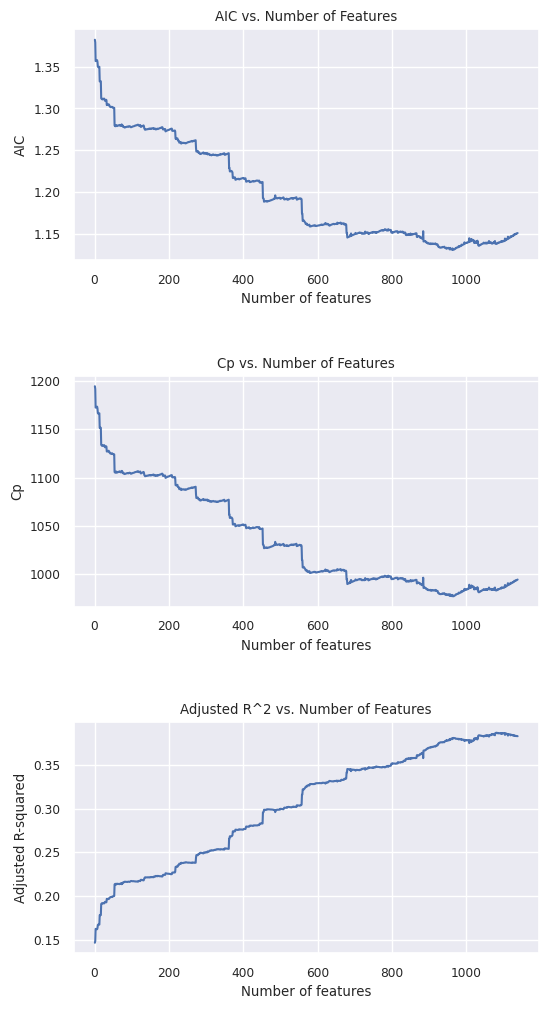

In [76]:
X_poly_df_selected = forward_stepwise_selec(X_features=X_poly_df, y_target=y, features_to_explore = X_poly_df.shape[1])

The best subset has 927 features out of the 1,139. Now, let's perform linear regression on the new dataframe.

In [85]:
# reset index
X_poly_df_selected = X_poly_df_selected.reset_index(drop=True)
y = y.reset_index(drop=True)

# fit model
model = sm.OLS(y, sm.add_constant(X_poly_df_selected)).fit()

# print summary and display only the first 30 lines
summary = model.summary()
lines = str(summary).split('\n')
print('\n'.join(lines[:30]), end='\n\n...')

                            OLS Regression Results                            
Dep. Variable:                   duis   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     6.084
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:07:34   Log-Likelihood:                -35763.
No. Observations:                7556   AIC:                         7.338e+04
Df Residuals:                    6628   BIC:                         7.981e+04
Df Model:                         927                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Calculate RMSE again

In [78]:
# Fit the OLS model
X_poly_df_selected_lin = sm.add_constant(X_poly_df_selected)  # add an intercept term
model = sm.OLS(y, X_poly_df_selected_lin).fit()

# Get the predicted values and calculate the RMSE
y_pred = model.predict(X_poly_df_selected_lin)
fss_dataframe_linear = np.sqrt(np.mean((y - y_pred)**2))

print('RMSE:', round(fss_dataframe_linear,2))

RMSE: 27.5


Although there is a significant number of insignicant variables, this models outperforms the base model by several points. The adjusted $R^2$ also increased considerably. However, let's now try by removing the insignificant variables from the model.

## FSS Significant Values Dataframe - Linear Regression

In [86]:
# get significant vars from previous model
model = sm.OLS(y, sm.add_constant(X_poly_df_selected)).fit()
significant_vars = model.pvalues[model.pvalues < 0.05].index.tolist()
significant_vars = original_features +significant_vars
significant_vars = list(set(significant_vars))

if 'const' in significant_vars:
    significant_vars.remove('const')  # remove the constant term

# create a new dataframe with only significant variables
X_poly_df_selected_signif = X_poly_df_selected[significant_vars]

# refit the OLS model with significant variables
model_signif = sm.OLS(y, sm.add_constant(X_poly_df_selected_signif)).fit()

# print summary and display only the first 30 lines
summary = model_signif.summary()
lines = str(summary).split('\n')
print('\n'.join(lines[:30]), end='\n\n...')


                            OLS Regression Results                            
Dep. Variable:                   duis   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     34.47
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:08:35   Log-Likelihood:                -36851.
No. Observations:                7556   AIC:                         7.387e+04
Df Residuals:                    7471   BIC:                         7.446e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [80]:
# Fit the OLS model
X_poly_df_selected_signif_lin = sm.add_constant(X_poly_df_selected_signif)  # add an intercept term
model = sm.OLS(y, X_poly_df_selected_signif_lin).fit()

# Get the predicted values and calculate the RMSE
y_pred = model.predict(X_poly_df_selected_signif_lin)
fss_significant_linear = np.sqrt(np.mean((y - y_pred)**2))

print('RMSE:', round(fss_significant_linear,2))

RMSE: 31.76


The performance worsened. Let's now try the same features but with Lasso.

## FSS Significant Values Dataframe - Lasso Regression

In [81]:
# Alpha values to try
alphas = np.arange(0.1, 100, 0.1)

# Initialize RMSE list
cv_rmse = []

for alpha in alphas:
    # Model
    lasso_reg = Lasso(alpha=alpha, max_iter=5000)
    
    # Get error and append
    rmse_scores = np.sqrt(-1 * cross_val_score(lasso_reg, X_poly_df_selected_signif, y, cv=5, scoring='neg_mean_squared_error'))    
    cv_rmse.append(np.mean(rmse_scores))

# Find value of lowest RMSE
best_alpha = alphas[np.argmin(cv_rmse)]

# Report
print(f"Best RMSE: {np.min(cv_rmse):.2f} (alpha={best_alpha:.1f})")

fss_significant_lasso = np.min(cv_rmse) # store

Best RMSE: 32.69 (alpha=0.8)


Not better. Now to try a non-linear method let's try with Support Vector Machines

## Analytical Dataframe - SVM

In [82]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                y, 
                                                test_size=0.2, random_state=42)

# Define kernels and C values to test
kernels = ['linear', 'poly', 'rbf']
C_values = [0.1, 1, 10, 100]

# Initialize arrays for scores
cv_scores = np.zeros((len(kernels), len(C_values)))

# loop
for i, kernel in enumerate(kernels):
    for j, C in enumerate(C_values):
        svm = SVR(kernel=kernel, C=C)
        scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_scores[i, j] = np.mean(-scores)

# Find best kernel and C value
best_kernel_idx, best_C_idx = np.unravel_index(np.argmin(cv_scores), cv_scores.shape)
best_kernel = kernels[best_kernel_idx]
best_C = C_values[best_C_idx]
print('Best kernel:', best_kernel)
print('Best C:', best_C)

# Fit final SVM model with best kernel and C value on entire training set
svm_final = SVR(kernel=best_kernel, C=best_C)
svm_final.fit(X_train, y_train)

# Evaluate final model on test set
y_pred_test = svm_final.predict(X_test)
analytical_dataframe_svm = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
print('Test RMSE:', round(analytical_dataframe_svm,2))


Best kernel: rbf
Best C: 100
Test RMSE: 32.14


Although RMSE did not improve, the fact that the best kernel was `rbf` and the previous low RMSE of the large model from Forward Stepwise Selection provides more insight that linear models may not be the best way to model the data. Lastly, let's also try the Support Vector Machine with the FSS Significant Values Dataframe. Future research should perform additional analysis with non-linear models.

## Summary:

Model and cross-validation RMSE

In [83]:
print(f'Analytical Dataframe - Linear Regression: {round(analytical_dataframe_linear,2)}')
print(f'Analytical Dataframe - Lasso Regression: {round(analytical_dataframe_lasso,2)}')
print(f'FSS Dataframe - Linear Regression: {round(fss_dataframe_linear,2)}')
print(f'FSS Significant Values Dataframe - Linear Regression: {round(fss_significant_linear,2)}')
print(f'FSS Significant Values Dataframe - Lasso Regression: {round(fss_significant_lasso,2)}')
print(f'Analytical Dataframe - SVM: {round(analytical_dataframe_svm,2)}')


Analytical Dataframe - Linear Regression: 33.04
Analytical Dataframe - Lasso Regression: 32.7
FSS Dataframe - Linear Regression: 27.5
FSS Significant Values Dataframe - Linear Regression: 31.76
FSS Significant Values Dataframe - Lasso Regression: 32.69
Analytical Dataframe - SVM: 32.14


# References

City of New York. (2022). 2020 Census Blocks - Tabular. NYC Open Data. https://data.cityofnewyork.us/City-Government/2020-Census-Blocks-Tabular/wmsu-5muw

Green Space Challenge. (2023a). Crime Open Database (Version 1.0) [Data set]. Redivis. https://redivis.com/datasets/212h-10r96ja9r?v=1.0

Green Space Challenge. (2023b). Tree Equity Score (Version 1.0) [Data set]. Redivis. https://redivis.com/datasets/0re0-f0xykh3hf?v=1.0

US Census Bureau. (2021). Understanding Geographic Identifiers (GEOIDs). Census.Gov. https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html



# Appendix

### 1. Crime Open Database Data Dictionary

* geoid: the blockgroup id
* total_pop: the total population of the block group
* state: the state the blockgroup is in
* county: the county the blockgroup is in
* pctpov: the percent of people in poverty inside the blockgroup
* pctpoc: the percent of people of color inside the block group
* unemplrate: the unemployment rate inside of the block group
* medhhinc: the median household income of the block group
* dep_ratio: the dependency ratio (childrens + seniors / 18-64 adults)
* child_perc: the percent of children inside of the blockgroup
* seniorperc: the percent of seniors inside of the blockgroup
* treecanopy: the tree canopy percentage of the blockgroup (set to negative 1 if the source is 'ED')
* area: the area of the blockgroup in square kilometers
* source: the source of the tree canopy of the block group
* avg_temp: the average temperature of the blockgroup on a hot summer's day
* ua_name: the urbanized area the block group is located inside
* incorpname: the incorporated place the block group is located inside
* congressio:  the congressional district of the block group
* biome:  the biome of the blockgroup
* bgpopdense: the density of the blockgroup (total population over area)
* popadjust: the population adjustment factor (based on the population density)
* tc_gap: the tree canopy gap of the block group (goal minus canopy)
* tc_goal: the tree canopy goal of the block group (set to negative 1 if the source is 'ED')
* phys_hlth: the self reported physical health challenges of the people in the block group (a percentage)
* ment_hlth:  the self reported mental health challenges of people in the block group (a percentage)
* asthma: the self reported asthma challenges of people in the block group (a percentage)
* core_m: the self reported male coronary heart challenges of people in the block group (a percentage)
* core_w: the self reported female coronary heart challenges of people in the block group (a percentage)
* core_norm: the normalized total coronary challenges of people in the block group
* healthnorm: the normalized health index of the block group
* priority: the priority index of the block group
* tes: the tree equity score of the block group
* tesctyscor: the tree equity score of the incorporated place/municipality of the block group
* geometry: the geometry of the block group